In [ ]:

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import os
import zipfile

In [ ]:
# Upload file
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_excel(filename)

Saving big5_players.xlsx to big5_players.xlsx


In [ ]:
template_name = "Lamine Yamal"

SHORTLIST PER 90

In [ ]:

# 1. Data Filtering

df = df[df["Minutes Played"] >= 800].reset_index(drop=True)

In [ ]:

# 2. Define Role

role_metrics = [
    'Goals', 'Shots', 'Average Shot Distance', 'Non-penalty Expected Goals',
    'Passes Attempted', 'Pass Completion%', 'Progressive Passing Distance', 'Progressive Passes',
    'Assists', 'Expected Assisted Goals', 'Expected Assists', 'Key Passes', 'Passes into the Penalty Area',
    'Through Balls', 'Switches', 'Crosses',
    'Shot-Creating Actions', 'Shot-Creating Live-ball Passes', 'Shot-Creating Dead-ball Passes',
    'Shot-Creating Take-ons', 'Goal-creating Actions',
    'Touches', 'Touches in the Defensive Third', 'Touches in the Middle Third',
    'Touches in the Attacking Third', 'Touches in the Attacking Penalty Area',
    'Take-ons Attempted', 'Take-ons Success %',
    'Carries', 'Progressive Carrying Distance', 'Progressive Carries', 'Carries into the Penalty Area',
    'Miscontrols', 'Dispossessed',
    'Passes Received', 'Progressive Passes Received'
]


df[role_metrics] = df[role_metrics].apply(lambda col: col.fillna(col.mean()))


template = df[df["Player"] == template_name][role_metrics].values.flatten()


In [ ]:

# 2b. Define Weights

weights = {
    'Goals':1,
    'Shots':1,
    'Average Shot Distance':1,
    'Non-penalty Expected Goals':1,
    'Passes Attempted':1,
    'Pass Completion%':1,
    'Progressive Passing Distance':1.5,
    'Progressive Passes':1.5,
    'Assists':2,
    'Expected Assisted Goals':2,
    'Expected Assists':2,
    'Key Passes':2,
    'Passes into the Penalty Area':1.8,
    'Through Balls':1.5,
    'Switches':1,
    'Crosses':1.5,
    'Shot-Creating Actions':2,
    'Shot-Creating Live-ball Passes':2,
    'Shot-Creating Dead-ball Passes':2,
    'Shot-Creating Take-ons':2,
    'Goal-creating Actions':2,
    'Touches':1,
    'Touches in the Defensive Third':1,
    'Touches in the Middle Third':1,
    'Touches in the Attacking Third':1,
    'Touches in the Attacking Penalty Area':1,
    'Take-ons Attempted':1,
    'Take-ons Success %':1,
    'Carries':1,
    'Progressive Carrying Distance':1.5,
    'Progressive Carries':1.5,
    'Carries into the Penalty Area':1.8,
    'Miscontrols':1,
    'Dispossessed':1,
    'Passes Received':1,
    'Progressive Passes Received':1
}

In [ ]:

# 3. Normalize / Scale + Apply Weights

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[role_metrics])
X_weighted = X_scaled * np.array([weights[m] for m in role_metrics])

template_scaled = scaler.transform([template])
template_weighted = template_scaled * np.array([weights[m] for m in role_metrics])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 4. Similarity Modeling (Weighted)

similarities = cosine_similarity(X_weighted, template_weighted).flatten()
df["Similarity"] = similarities

In [ ]:

# 5. Shortlist Function

def get_shortlist(age_limit=40, top_n=20):
    shortlist = df[df["Player"] != template_name].copy()
    shortlist = shortlist[shortlist["Age"] <= age_limit]
    shortlist = shortlist.sort_values("Similarity", ascending=False).reset_index(drop=True)
    shortlist["Rank"] = shortlist.index + 1
    return shortlist.head(top_n)

In [ ]:

# 6. Radar Plot Function

def radar_plot(player_name, template_name=template_name, save_path=None):
    player_stats = df[df["Player"] == player_name][role_metrics].values.flatten()
    player_stats = np.nan_to_num(player_stats, nan=np.nanmean(player_stats))

    player_scaled = scaler.transform([player_stats]).flatten()
    template_scaled_vals = template_scaled.flatten()

    labels = role_metrics
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

    # Template
    values = np.concatenate((template_scaled_vals, [template_scaled_vals[0]]))
    ax.plot(angles, values, color="red", linewidth=2, label=template_name)
    ax.fill(angles, values, color="red", alpha=0.25)

    # Player
    values = np.concatenate((player_scaled, [player_scaled[0]]))
    ax.plot(angles, values, color="blue", linewidth=2, label=player_name)
    ax.fill(angles, values, color="blue", alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_title(f"{player_name} vs {template_name}", size=12, weight="bold")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# 7. Age Slider

age_slider = widgets.IntSlider(
    value=23, min=18, max=40, step=1,
    description="Max Age:", continuous_update=False
)

def update_shortlist(age_limit):
    top20 = get_shortlist(age_limit, top_n=20)
    print(f"🔎 Top 20 Playmakers similar to {template_name} (Age ≤ {age_limit})")
    display(top20[["Rank","Player", "Club", "Age", "Minutes Played", "Similarity"]])
    return top20

out = widgets.interactive_output(update_shortlist, {"age_limit": age_slider})
display(age_slider, out)

# 8. Radar Dropdown
def interactive_radar(age_limit):
    shortlist = get_shortlist(age_limit, top_n=20)
    dropdown = widgets.Dropdown(
        options=shortlist["Player"].tolist(),
        description="Select Player:",
        layout=widgets.Layout(width="400px")
    )
    def on_player_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            radar_plot(change['new'])
    dropdown.observe(on_player_change)
    display(dropdown)

interactive_radar(age_slider.value)


IntSlider(value=23, continuous_update=False, description='Max Age:', max=40, min=18)

Output()

Dropdown(description='Select Player:', layout=Layout(width='400px'), options=('Florian Wirtz', 'Désiré Doué', …

SHORTLIST PER 100 TOUCHES

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from google.colab import files
import ipywidgets as widgets
from IPython.display import display
import os
import zipfile

In [ ]:

# 1. Data Filtering

df = df[df["Minutes Played"] >= 800].reset_index(drop=True)

In [ ]:

# 2. Define Role Metrics

role_metrics = [
    'Goals', 'Shots', 'Average Shot Distance', 'Non-penalty Expected Goals',
    'Passes Attempted', 'Pass Completion%', 'Progressive Passing Distance', 'Progressive Passes',
    'Assists', 'Expected Assisted Goals', 'Expected Assists', 'Key Passes', 'Passes into the Penalty Area',
    'Through Balls', 'Switches', 'Crosses',
    'Shot-Creating Actions', 'Shot-Creating Live-ball Passes', 'Shot-Creating Dead-ball Passes',
    'Shot-Creating Take-ons', 'Goal-creating Actions',
    'Touches', 'Touches in the Defensive Third', 'Touches in the Middle Third',
    'Touches in the Attacking Third', 'Touches in the Attacking Penalty Area',
    'Take-ons Attempted', 'Take-ons Success %',
    'Carries', 'Progressive Carrying Distance', 'Progressive Carries', 'Carries into the Penalty Area',
    'Miscontrols', 'Dispossessed',
    'Passes Received', 'Progressive Passes Received'
]


for col in role_metrics:
    df[col] = df[col].fillna(df[col].mean())


for metric in role_metrics:
    if metric != "Touches":
        df[f"{metric}_per100"] = df[metric] / df["Touches"] * 100


role_metrics_per100 = [f"{metric}_per100" for metric in role_metrics if metric != "Touches"]



In [ ]:
# 2b. Define Weights
weights = {
    'Goals':1,
    'Shots':1,
    'Average Shot Distance':1,
    'Non-penalty Expected Goals':1,
    'Passes Attempted':1,
    'Pass Completion%':1,
    'Progressive Passing Distance':1.5,
    'Progressive Passes':1.5,
    'Assists':2,
    'Expected Assisted Goals':2,
    'Expected Assists':2,
    'Key Passes':2,
    'Passes into the Penalty Area':1.8,
    'Through Balls':1.5,
    'Switches':1,
    'Crosses':1.5,
    'Shot-Creating Actions':2,
    'Shot-Creating Live-ball Passes':2,
    'Shot-Creating Dead-ball Passes':2,
    'Shot-Creating Take-ons':2,
    'Goal-creating Actions':2,
    'Touches':1,
    'Touches in the Defensive Third':1,
    'Touches in the Middle Third':1,
    'Touches in the Attacking Third':1,
    'Touches in the Attacking Penalty Area':1,
    'Take-ons Attempted':1,
    'Take-ons Success %':1,
    'Carries':1,
    'Progressive Carrying Distance':1.5,
    'Progressive Carries':1.5,
    'Carries into the Penalty Area':1.8,
    'Miscontrols':1,
    'Dispossessed':1,
    'Passes Received':1,
    'Progressive Passes Received':1
}

In [ ]:
# Map per100 names
weights_per100 = {f"{metric}_per100": weights.get(metric, 1.0) for metric in role_metrics if metric != "Touches"}

In [ ]:
# 3. Normalize / Scale + Apply Weights
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df[role_metrics_per100])
X_weighted = X_scaled * np.array([weights_per100[m] for m in role_metrics_per100])

template_row = df[df["Player"] == template_name].iloc[0]

template = template_row[role_metrics_per100].values

template_scaled = scaler.transform([template])
template_weighted = template_scaled * np.array([weights_per100[m] for m in role_metrics_per100])

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
# 4. Similarity Modeling (Weighted)
similarities = cosine_similarity(X_weighted, template_weighted).flatten()
df["Similarity"] = similarities

In [ ]:
# 6. Shortlist Function
def get_shortlist(age_limit=40, top_n=20):
    shortlist = df[df["Player"] != template_name].copy()
    shortlist = shortlist[shortlist["Age"] <= age_limit]
    shortlist = shortlist.sort_values("Similarity", ascending=False).reset_index(drop=True)
    shortlist["Rank"] = shortlist.index + 1
    return shortlist.head(top_n)

In [ ]:

# 7. Radar Plot Function
def radar_plot(player_name, template_name=template_name, save_path=None):
    player_stats = df[df["Player"] == player_name][role_metrics_per100].values.flatten()
    player_stats = np.nan_to_num(player_stats, nan=np.nanmean(player_stats))

    player_scaled = scaler.transform([player_stats]).flatten()
    template_scaled_vals = template_scaled.flatten()

    labels = role_metrics
    angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(7,7), subplot_kw=dict(polar=True))

    # Template
    values = np.concatenate((template_scaled_vals, [template_scaled_vals[0]]))
    ax.plot(angles, values, color="red", linewidth=2, label=template_name)
    ax.fill(angles, values, color="red", alpha=0.25)

    # Player
    values = np.concatenate((player_scaled, [player_scaled[0]]))
    ax.plot(angles, values, color="blue", linewidth=2, label=player_name)
    ax.fill(angles, values, color="blue", alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=7)
    ax.set_title(f"{player_name} vs {template_name} (per 100 touches)", size=12, weight="bold")
    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        plt.close(fig)
    else:
        plt.show()

# 8. Age Slider
age_slider = widgets.IntSlider(
    value=23, min=16, max=40, step=1,
    description="Max Age:", continuous_update=False
)

def update_shortlist(age_limit):
    top20 = get_shortlist(age_limit, top_n=20)
    print(f"🔎 Top 20 Playmakers similar to {template_name} (Age ≤ {age_limit}, per 100 touches)")
    display(top20[["Rank","Player", "Club", "Age", "Minutes Played", "Similarity"]])
    return top20

out = widgets.interactive_output(update_shortlist, {"age_limit": age_slider})
display(age_slider, out)

# 9. Radar Dropdown
def interactive_radar(age_limit):
    shortlist = get_shortlist(age_limit, top_n=20)
    dropdown = widgets.Dropdown(
        options=shortlist["Player"].tolist(),
        description="Select Player:",
        layout=widgets.Layout(width="400px")
    )
    def on_player_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            radar_plot(change['new'])
    dropdown.observe(on_player_change)
    display(dropdown)

interactive_radar(age_slider.value)


IntSlider(value=23, continuous_update=False, description='Max Age:', max=40, min=16)

Output()

Dropdown(description='Select Player:', layout=Layout(width='400px'), options=('Florian Wirtz', 'Antonio Nusa',…

PIZZA

In [ ]:
pip install highlight_text

In [ ]:
pip install mplsoccer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.4/86.4 kB 2.8 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
from highlight_text import fig_text

from mplsoccer import PyPizza, FontManager

In [ ]:
font_normal = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Regular.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/googlefonts/roboto/main/'
                          'src/hinted/Roboto-Italic.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab[wght].ttf')

In [ ]:
params =  ['Goals', 'npxG', 'Shots',
           'Assists', 'xAG', 'Shot-creating Actions',
          'Passes Att.', 'Pass Comp. %', 'Prog. Passes',
          'Prog. Carries',
          'Succ. Take-ons', 'Touches Att.Pen.Area', 'Prog. Passes Rec.',
          'Tackles', 'Interceptions', 'Blocks', 'Clearances', 'Aerials Won']

In [ ]:
values = [47,58,55,
          84,95,85,
          92,18,97,
          53,22,50,51,
          7,15,9,2,7]

In [ ]:
len(params)

18

In [ ]:
slice_colors = ["#6DADDD"] * 18
text_colors = ["#0"] * 18

In [ ]:
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#1b1b1b",     # background color
    straight_line_color="#ffffff",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_color="#ffffff",    # color for last line
    last_circle_lw=1,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    inner_circle_size=20            # size of inner circle
)

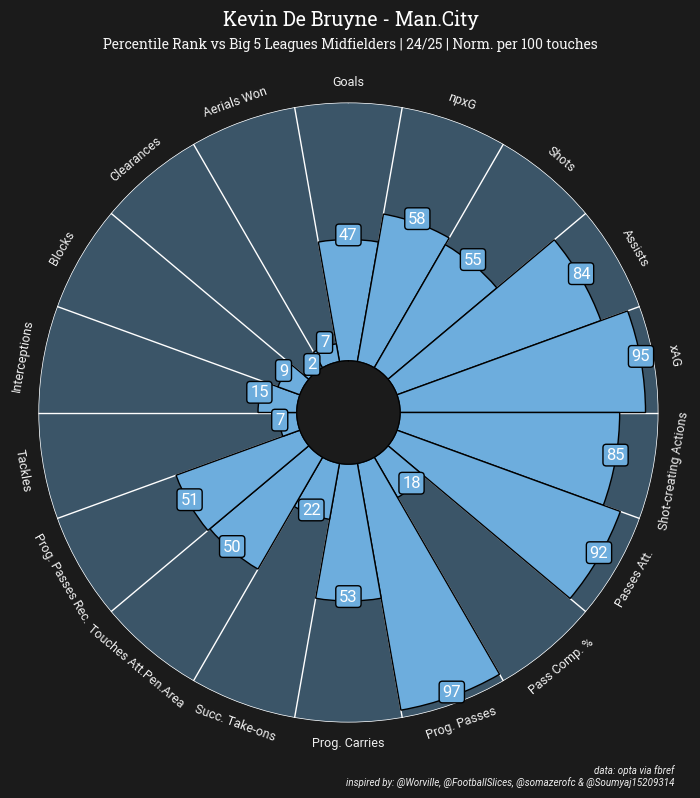

In [ ]:
fig, ax = baker.make_pizza(
    values,                          # list of values
    figsize=(8, 9),                # adjust the figsize according to your need
    color_blank_space="same",        # use the same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#000000", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#F2F2F2", fontsize=9,
        fontproperties=font_normal.prop, va="center"
    ),                               # values to be used when adding parameter labels
    kwargs_values=dict(
        color="#F2F2F2", fontsize=12,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values labels
)

# add title
fig.text(
    0.515, 0.925, "Kevin De Bruyne - Man.City", size=14,
    ha="center", fontproperties=font_bold.prop, color="#FFFFFF"
)

# add subtitle
fig.text(
    0.515, 0.9,
    "Percentile Rank vs Big 5 Leagues Midfielders | 24/25 | Norm. per 100 touches",
    size=10,
    ha="center", fontproperties=font_bold.prop, color="#F2F2F2"
)

# add credits
CREDIT_1 = "data: opta via fbref"
CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

fig.text(
    0.92, 0.08, f"{CREDIT_1}\n{CREDIT_2}", size=7,
    fontproperties=font_italic.prop, color="#F2F2F2",
    ha="right"
)




plt.show()